In [1]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from gensim.models import word2vec


In [20]:
def get_Model():  # скачивает с rus_vectores модель
    rq = urllib.request.urlretrieve('http://rusvectores.org/static/models/'
                                    'rusvectores2/'
                                    'ruscorpora_mystem_cbow_300_2_2015.bin.gz',
                                    'ruscorpora_mystem_cbow_300_2_2015.bin.gz')
    return

get_Model()


In [137]:
def make_Model():  # делает для скачанной модели word2vec
    m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'
    if m.endswith('.bin.gz'):  # делает вектора
        model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
    # выбираем семантическое поле "театр" и проверяем некоторые слова
    print('Косинусная близость для "театр" и "сцена": ',
          model.similarity("театр_S", "сцена_S"))
    print('Косинусная близость для "театр" и "актер": ',
          model.similarity("театр_S", "актер_S"))
    print('Косинусная близость для "актер" и "сцена": ',
          model.similarity("актер_S", "сцена_S"))
    # все подходит для выбора поля и слов
    return model


In [138]:
import networkx as nx


def create_Graph(model):  # ищет слова и близкие к ним в модели
    start_words = ["театр_S", "сцена_S", "актер_S"]  # начальные слова
    G = nx.Graph()  # пустой граф
    G.add_nodes_from(start_words)  # добавляем несколько узлов сразу
    # по модели ищем слова первого порядка для каждого слова списка
    for word in start_words:
        par_speech = re.search(r'_([A-Za-z]+)', word)
        morpho = par_speech.group(1)  # часть речи выбранного слова из списка
        if word in model:  # если слово в модели
            # выбор первых слов по векторам для выбранного
            for i in model.most_similar(positive=[word], topn=15):
                # часть речи нового слова
                par_speech2 = re.search(r'_([A-Za-z]+)', i[0])
                morpho2 = par_speech2.group(1)
                # проверяется близость первого слова с новым и часть речи
                if i[1] >= 0.5 and morpho == morpho2:
                    # добавляет ребра в граф
                    G.add_edge(word, i[0])
                    # соседи второго порядка
                    if i[0] in model:
                        for el in model.most_similar(positive=[i[0]], topn=15):
                            # часть речи соседей
                            par_speech3 = re.search(r'_([A-Za-z]+)', el[0])
                            morpho3 = par_speech3.group(1)
                            # проверка части речи и близости с предыдущим
                            if el[1] >= 0.5 and morpho2 == morpho3:
                                # пополнение ребер графа
                                G.add_edge(i[0], el[0])
    return G


In [139]:
def analysis(G):  # вычисляет все метрики
    print("\n...\nЧисло узлов: ", G.number_of_nodes())
    print("Число ребер: ", G.number_of_edges())
    # Радиус графа, минимальный эксцентриситет среди всех вершин графа
    print("Радиус графа: ", nx.radius(G))
    # Диаметр графа, самый длинный путь от одной вершины до другой
    print("Диаметр графа: ", nx.diameter(G))
    # Коэффициент ассортативности
    print("Коэффициент ассортативности: ",
          nx.degree_pearson_correlation_coefficient(G))
    # Коэффициент классетризации
    print("Коэфициент классетризации: ", nx.average_clustering(G))
    # Плотность графа, отношение рёбер и узлов
    print("Плотность графа: ", nx.density(G), "\n...\n")
    # узлы, у которых больше всего связей
    deg_cen = nx.degree_centrality(G)
    for nodeid in sorted(deg_cen, key=deg_cen.get,
                         reverse=True)[:3]:
        print("Центральность узлов по degree centrality для",
              nodeid, ":", deg_cen[nodeid])
    # по количеству кратчашийх путей через узел
    bet_cen = nx.betweenness_centrality(G)
    for nodeid in sorted(bet_cen, key=bet_cen.get, reverse=True)[:3]:
        print("Центральность узлов по betweenness centrality для",
              nodeid, ":", bet_cen[nodeid])
    # узлы, которые более центральные
    clos_cen = nx.closeness_centrality(G)
    for nodeid in sorted(clos_cen, key=clos_cen.get, reverse=True)[:3]:
        print("Центральность узлов по closeness centrality для",
              nodeid, ":", clos_cen[nodeid])
    # узлы, у соседей которых больше всего соседей
    eig_cen = nx.eigenvector_centrality(G)
    for nodeid in sorted(eig_cen, key=eig_cen.get, reverse=True)[:3]:
        print("Центральность узлов по eigenvector centrality для",
              nodeid, ":", eig_cen[nodeid])


In [140]:
from networkx.algorithms import community
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')


def groups(G):  # делает граф по параметрам
    sizes = {}  # в словаре будет узел с размером
    for_node_1 = []  # размеры
    for_node_2 = []  # размеры
    for_node_3 = []  # размеры
    coun_nodes = G.number_of_nodes()
    # используем метрику количества связей
    deg_cen = nx.degree_centrality(G)
    for nodeid in sorted(deg_cen, key=deg_cen.get,
                         reverse=True):
        sizes[nodeid] = deg_cen[nodeid]*2500  # пополнение словаря
    # определение сообществ
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    comm = sorted(map(sorted, next_level_communities))
    number = 0
    print("\n...\nСообщества:\n")
    for group in comm:  # вывод сообществ
        number += 1
        print("\tСообщество", number, ":", group, "\n")
    # определяем размеры для слов по сообществам
    for words in comm[0]:
        for key, value in sizes.items():
            if words == key:
                for_node_1.append(value)
    for words in comm[1]:
        for key, value in sizes.items():
            if words == key:
                for_node_2.append(value)
    for words in comm[2]:
        for key, value in sizes.items():
            if words == key:
                for_node_3.append(value)
    pos = nx.spring_layout(G)  # способ укладки
    # размер фигуры
    plt.figure(figsize=(20, 20), dpi=300)
    # передаем информацию о ребрах, узлах и лейблах
    nx.draw_networkx_nodes(G, pos, comm[0], node_color="wheat",
                           node_size=for_node_1)
    nx.draw_networkx_nodes(G, pos, comm[1], node_color="coral",
                           node_size=for_node_2)
    nx.draw_networkx_nodes(G, pos, comm[2], node_color="lavender",
                           node_size=for_node_3)
    nx.draw_networkx_edges(G, pos, edge_color='teal')
    nx.draw_networkx_labels(G, pos, font_size=12,
                            font_family='Arial')
    plt.axis('off')
    # визуализируем
    plt.savefig("graph.png", dpi=300, fromat='png', bbox_inches='tight')


Сообщества:


    1.  к первой группе относятся все, что связано с жанровой программ в театре, места, в которых эти жанры реализуются
    
    2.  ко второй - люди, которые работают на благо театра и всего, что с ним связано
      
    3.  к третьей - атрибутика театрального выступления: все мелкие детали, прогоны, роли и тому подобное

Косинусная близость для "театр" и "сцена":  0.5443412444602032
Косинусная близость для "театр" и "актер":  0.5771754278425265
Косинусная близость для "актер" и "сцена":  0.5825200947407291

...
Число узлов:  142
Число ребер:  284
Радиус графа:  3
Диаметр графа:  5
Коэффициент ассортативности:  -0.27634504600629545
Коэфициент классетризации:  0.2741026010937274
Плотность графа:  0.028368794326241134 
...

Центральность узлов по degree centrality для спектакль_S : 0.14893617021276595
Центральность узлов по degree centrality для артист_S : 0.1347517730496454
Центральность узлов по degree centrality для актриса_S : 0.12056737588652482
Центральность узлов по betweenness centrality для актер_S : 0.35492046138345973
Центральность узлов по betweenness centrality для сцена_S : 0.27448604219834666
Центральность узлов по betweenness centrality для спектакль_S : 0.17772740882118618
Центральность узлов по closeness centrality для актер_S : 0.4592833876221498
Центральность узлов по closeness central

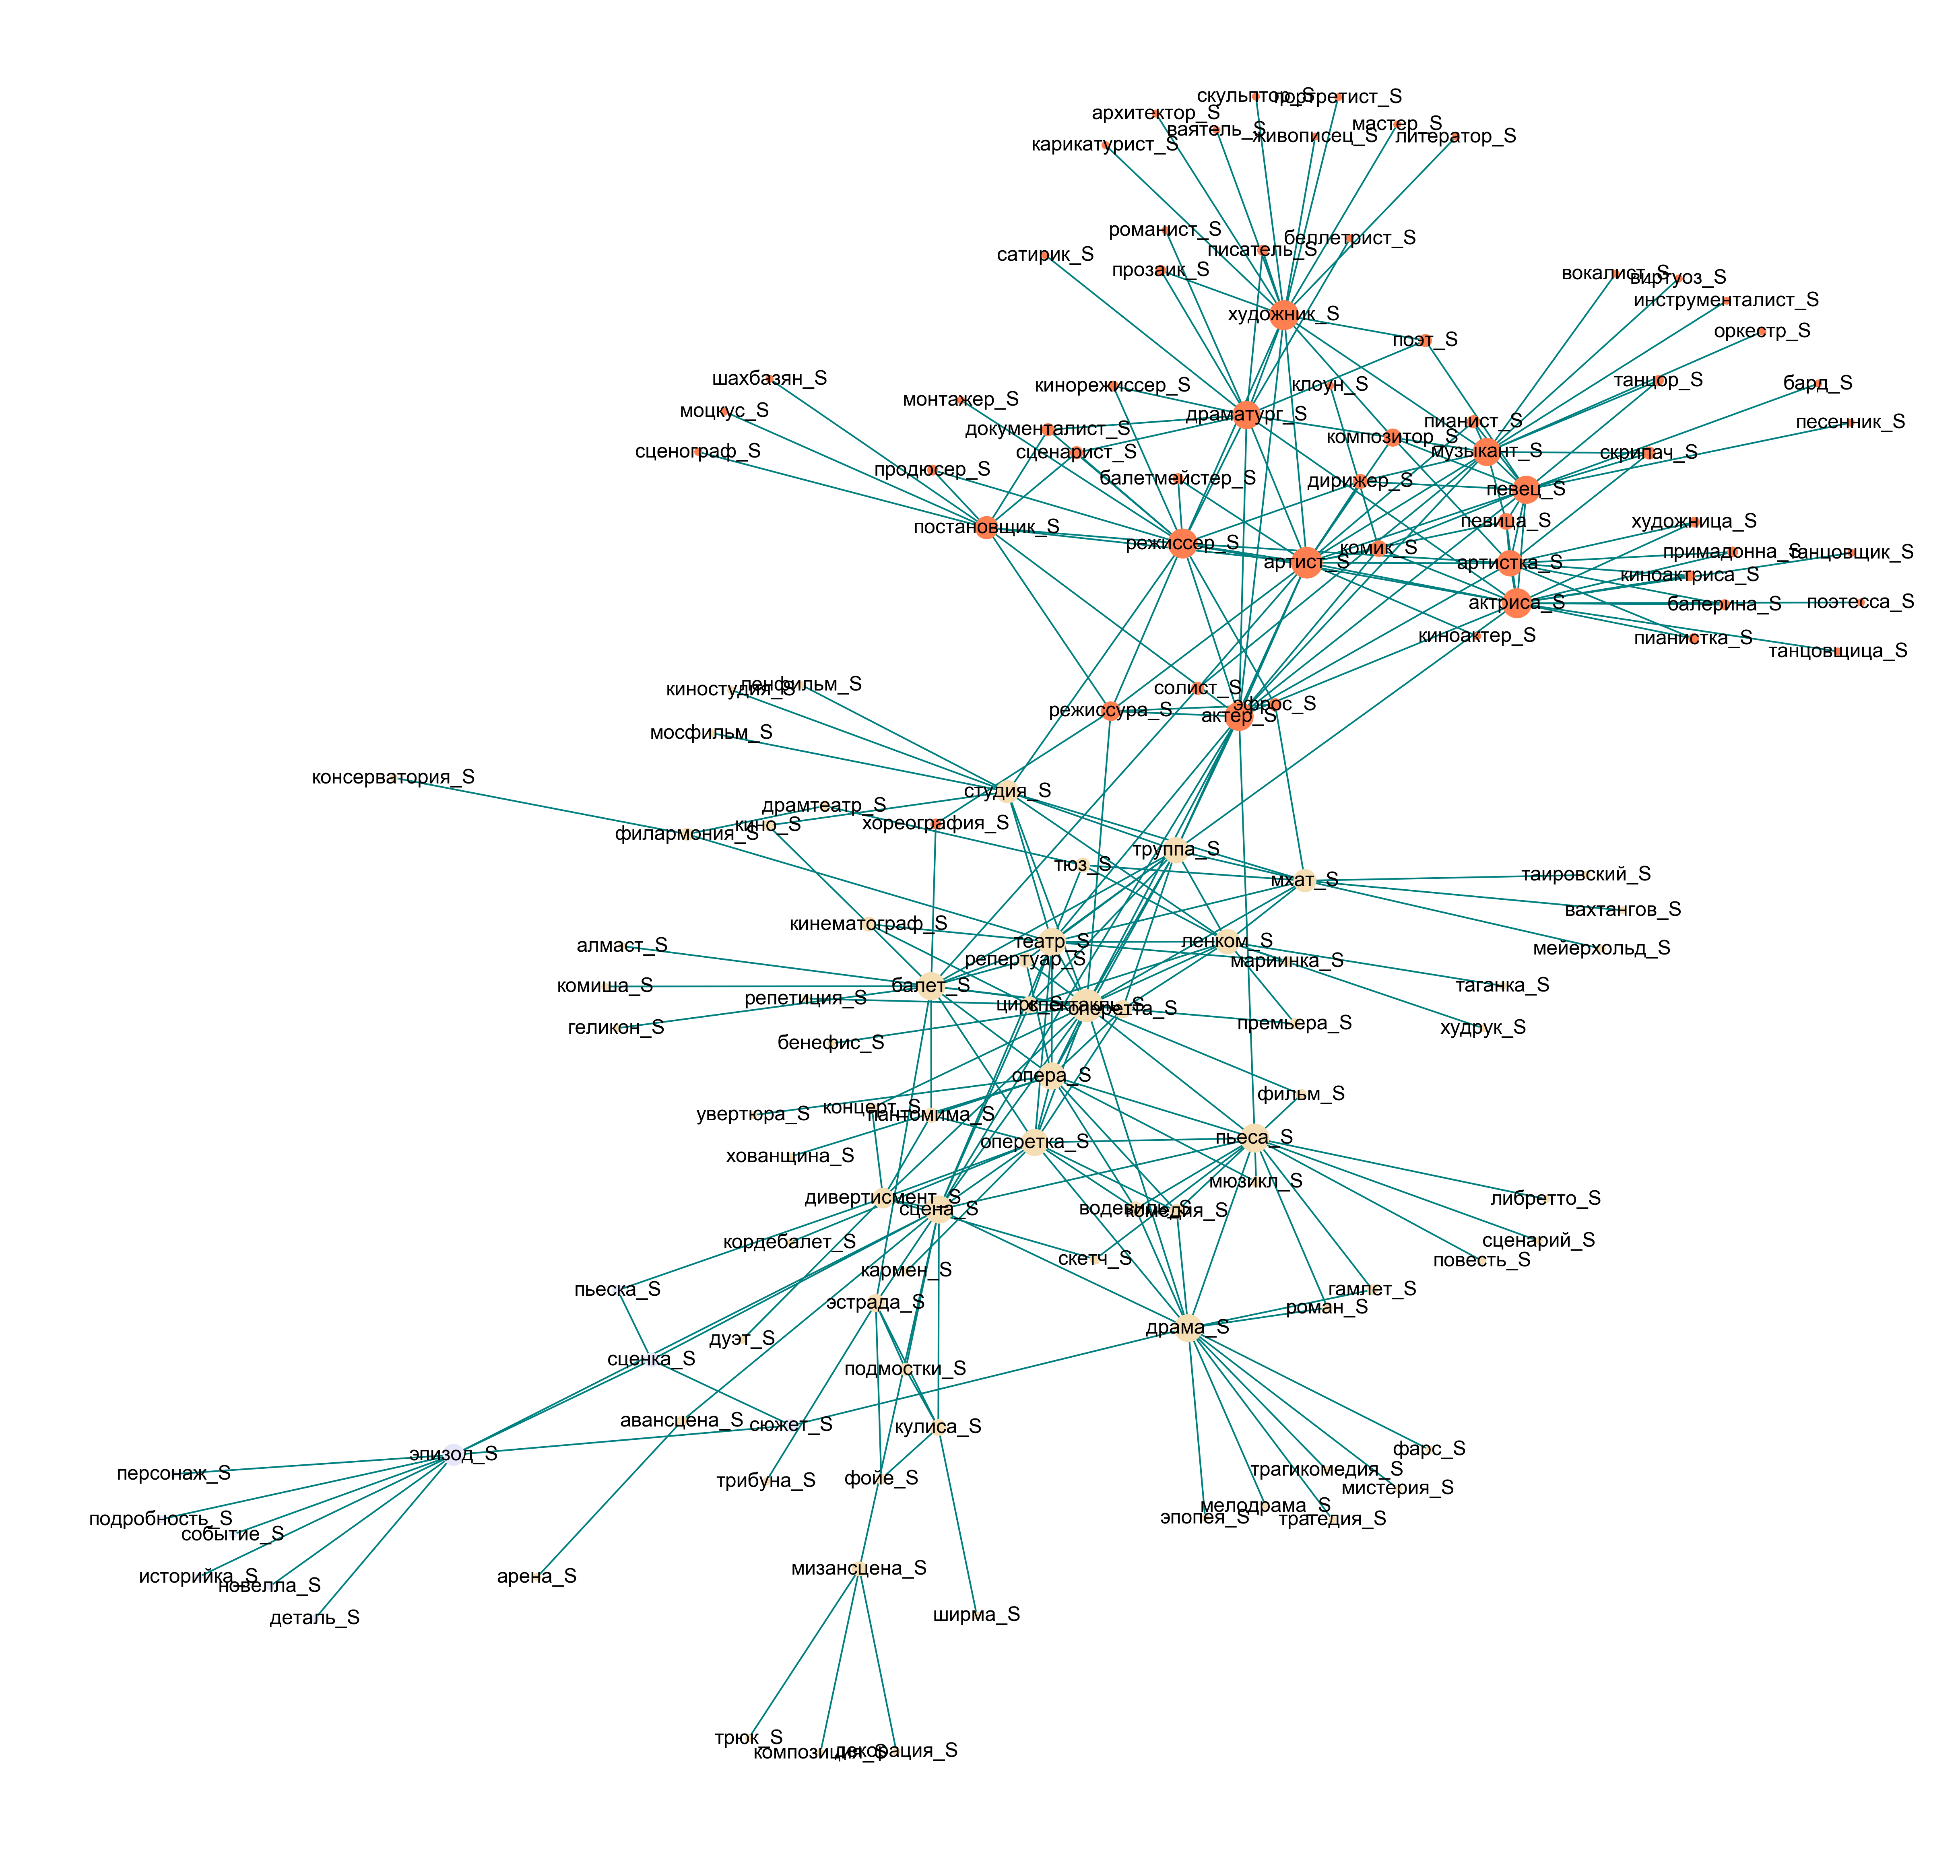

In [141]:
def main():  # запускает функции
    model2vec = make_Model()
    for_words = create_Graph(model2vec)
    gragh_analize = analysis(for_words)
    communities = groups(for_words)


main()


#### Цвета: показывают соотнесенность с сообществами

1. бежевый - сообщество 1
2. кораловый - сообщество 2
3.  лавандовый - сообщество 3

#### Размер узлов: показывает у кого больше свзяей
    
    Чем больше связей у узла, тем он больше. За основу принято количество слов в графе.